# Data Cleaning and Exploration

#####

In [42]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
from pmdarima import auto_arima # type: ignore # pandas and numpy version have to be downgraded

In [43]:
def plot_time_series(df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Total'])
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel("Total Occupancy")
    plt.grid(True)
    plt.show()

In [44]:
df = pd.read_csv('./data/cleanedData.csv')

In [45]:
print(df.isnull().sum())
print(df.isna().sum())

Date           0
Time           0
Total       7405
lvl1nswe    7405
lvl2e       7405
lvl3e       7405
lvl3nsw     7405
lvl4e       7405
lvl4nsw     7405
dtype: int64
Date           0
Time           0
Total       7405
lvl1nswe    7405
lvl2e       7405
lvl3e       7405
lvl3nsw     7405
lvl4e       7405
lvl4nsw     7405
dtype: int64


In [46]:
# Select rows with at least one NaN/null value
rows_with_nan = df[df.isnull().any(axis=1)]

rows_with_nan.head()
# rows_with_nan.to_csv('./data/missingData.csv'), no particular trend / events for missing data.
df = df.ffill()
print(df.isnull().sum())
print(df.isna().sum())


Date        0
Time        0
Total       0
lvl1nswe    0
lvl2e       0
lvl3e       0
lvl3nsw     0
lvl4e       0
lvl4nsw     0
dtype: int64
Date        0
Time        0
Total       0
lvl1nswe    0
lvl2e       0
lvl3e       0
lvl3nsw     0
lvl4e       0
lvl4nsw     0
dtype: int64


In [47]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Total'] = df['Total'].str.replace(',', '').astype(int)

In [48]:

df_total = df[['Datetime','Total']]
df_total.set_index('Datetime', inplace=True)
df_total = df_total.sort_index()

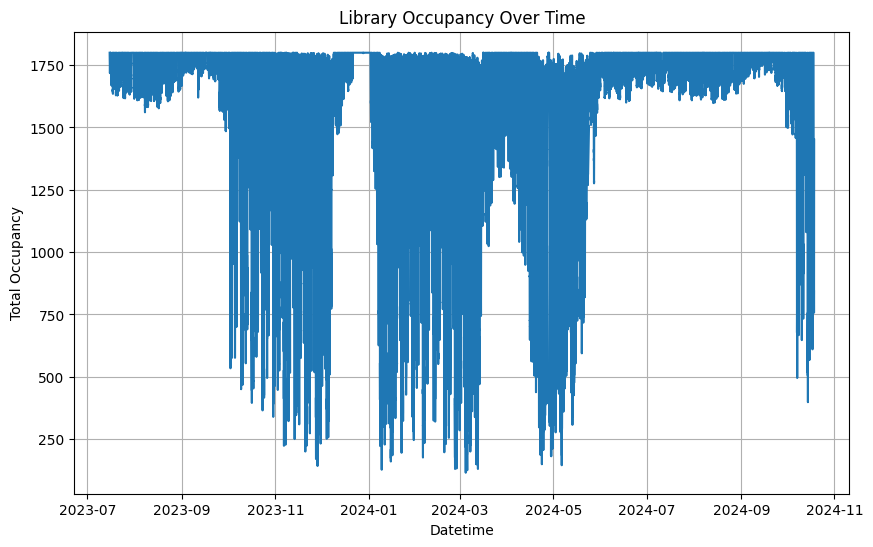

In [49]:
plot_time_series(df_total, "Library Occupancy Over Time")

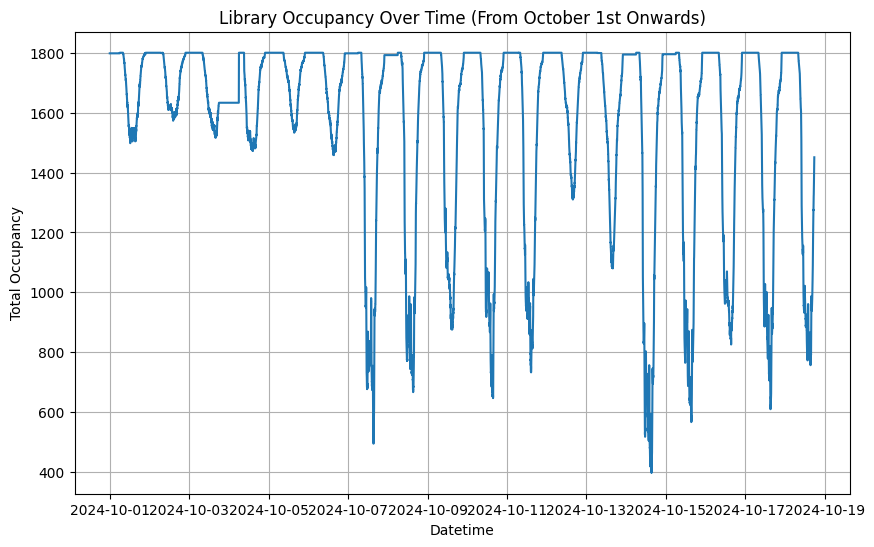

In [50]:
start_date = '2024-10-01'  # Current academic year
df_total_oct_onwards = df_total[df_total.index >= start_date]
plot_time_series(df_total_oct_onwards, "Library Occupancy Over Time (From October 1st Onwards)")

# Data Augmentation
##### We observe seasonality (seems stationary!) in our model, however there is a too much noise for a simple SARIMA model to capture. However, we can mitigate this (results pending) by utilizing exogenous information such as day of the week, holidays and academic periods (called a SARIMAX model).

In [51]:
start_date = '2024-10-07'  # Current academic year
df_augmentation = df_total[df_total.index >= start_date].copy()  # Explicit copy to avoid warning

# Exogenous Variable... room to add more university specific stuff later (holidays, e.c.t.)
df_augmentation['Day'] = df_augmentation.index.dayofweek 
df_augmentation = pd.get_dummies(df_augmentation, columns=['Day'], drop_first=True) # to avoid bias, as 6 -> 0
print(df_augmentation.shape)
df_augmentation.head()

(16615, 7)


,Total,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
Datetime,,,,,,,
2024-10-07 00:00:00,1798,False,False,False,False,False,False
2024-10-07 00:01:00,1798,False,False,False,False,False,False
2024-10-07 00:02:00,1798,False,False,False,False,False,False
2024-10-07 00:03:00,1798,False,False,False,False,False,False
2024-10-07 00:04:00,1798,False,False,False,False,False,False


(282, 7)


/var/folders/gg/2xgfrwhs60j8qg5zm5gbky_c0000gn/T/ipykernel_36227/137371760.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_augmentation_hourly = df_augmentation.resample('H').mean()


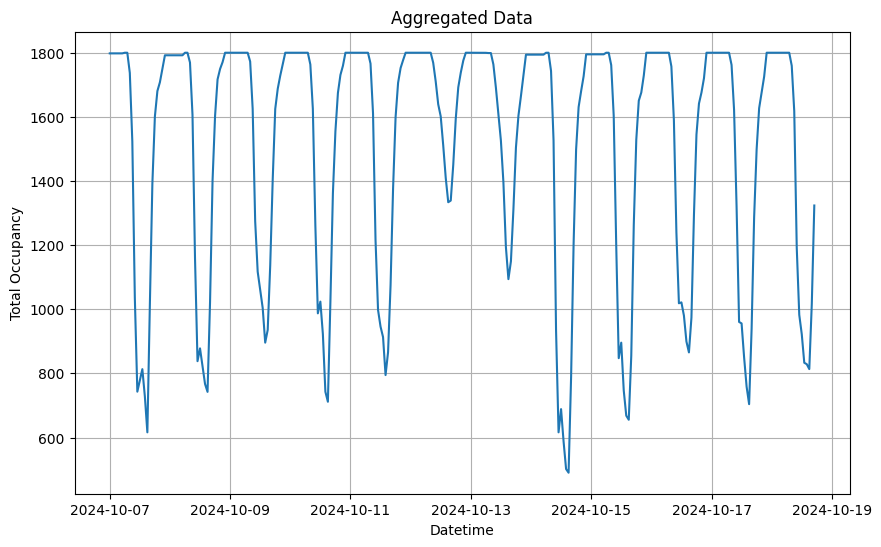

2024-10-07 00:00:00 2024-10-18 17:00:00


In [52]:
# Aggregate data to smooth out plots
df_augmentation_hourly = df_augmentation.resample('H').mean()
print(df_augmentation_hourly.shape)
plot_time_series(df_augmentation_hourly, "Aggregated Data")
print(df_augmentation_hourly.index.min(), df_augmentation_hourly.index.max())

# SARIMAX Modelling

##### Chosen because:

In [53]:
# Just to be safe.
df_main = df_augmentation_hourly.copy() 
df_main = df_main.sort_index()

test_rows = 72 # 72hrs 
# Correct split
training_data = df_main.iloc[:-test_rows]  # Data before the last 72 hours
test_data = df_main.iloc[-test_rows:]  # Last 72 hours for testing

# Split features and target
training_x = training_data.drop(columns=['Total'])  
training_y = training_data['Total'] 

test_x = test_data.drop(columns=['Total']) 
test_y = test_data['Total']

# Ensure correct split.
print("Training set (X):", training_x.shape)
print("Training set (Y):", training_y.shape)
print("Test set (X):", test_x.shape)
print("Test set (Y):", test_y.shape)



Training set (X): (210, 6)
Training set (Y): (210,)
Test set (X): (72, 6)
Test set (Y): (72,)


In [54]:
seasonality = 24
model = auto_arima(
    y=training_y, 
    x=training_x, 
    m=seasonality, 
    seasonal=True, 
    trace=True,
    max_p=10, max_q=10, max_P=7, max_Q=7, 
    max_d=7, max_D=7,
    stepwise=True
)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=2393.196, Time=12.03 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=3099.575, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3686.961, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=2425.687, Time=7.73 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=2391.434, Time=11.18 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=2490.526, Time=0.62 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=2392.021, Time=22.68 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=21.12 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=2376.262, Time=7.03 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=2516.308, Time=0.40 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=2370.020, Time=20.44 sec
 ARIMA(1,0,2)(3,0,0)[24] intercept   : AIC=2345.413, Time=61.03 sec
 ARIMA(1,0,2)(4,0,0)[24] int

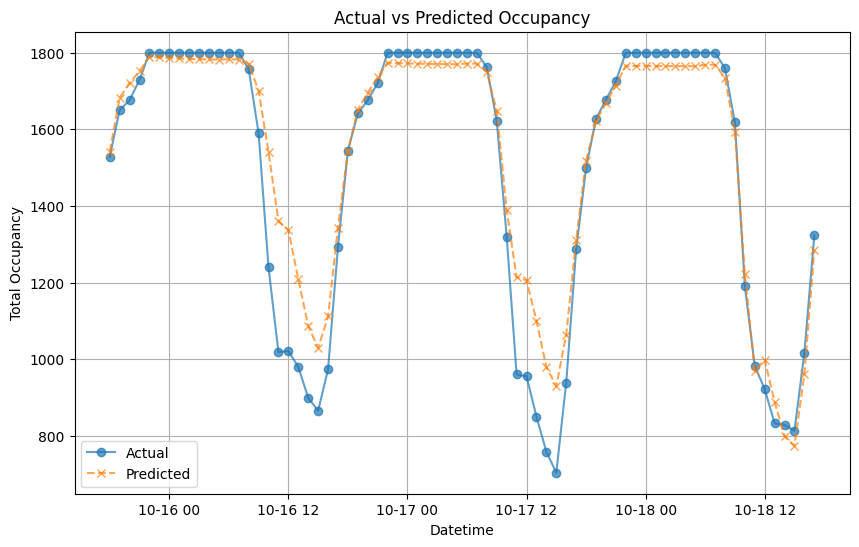

In [55]:
predicted_y = model.predict(n_periods=test_y.shape[0])

# Plot the test results against the predicted results
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label="Actual", marker='o', linestyle='-', alpha=0.7)
plt.plot(test_y.index, predicted_y, label="Predicted", marker='x', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Occupancy")
plt.xlabel("Datetime")
plt.ylabel("Total Occupancy")
plt.legend()
plt.grid(True)
plt.show()